# Application 2 - extracting linear features from a DEM

1.0 1.0
9.40377
1 0 min theta =  14.0362434679 ( 26.0 )
1417
1 0 min theta =  6.34019174591 ( 57.0 )
624
1 0 min theta =  4.08561677997 ( 88.0 )
300
1 0 min theta =  3.01278750418 ( 119.0 )
166
1 0 min theta =  1.6846843179 ( 214.0 )
22


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:225: RuntimeWarning: invalid value encountered in sqrt


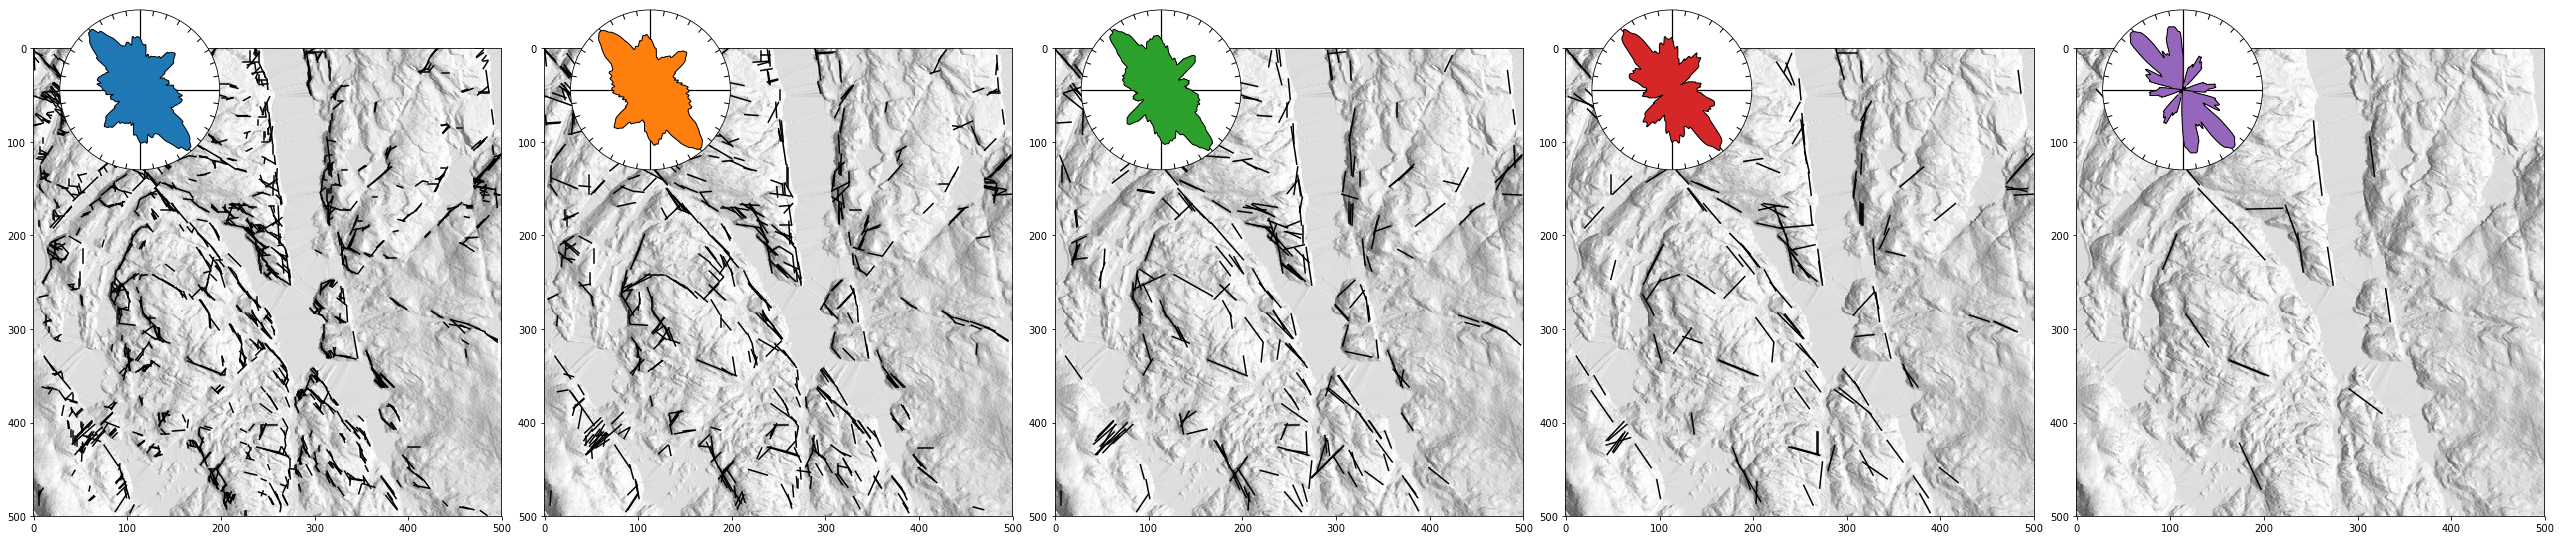

['1_1', '2_1', '3_1', '4_1', '5_1']


In [170]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap,shiftgrid#, cm
from matplotlib.colors import LightSource
from osgeo import osr, gdal
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import measure, feature, io, color, draw, morphology, restoration, filters
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import collections



fig = plt.figure(figsize=(45,10))


gs = gridspec.GridSpec(3, 10)

ax1 = plt.subplot(gs[:,0:2])
ax2 = plt.subplot(gs[:,2:4])
ax3 = plt.subplot(gs[:,4:6])
ax4 = plt.subplot(gs[:,6:8])
ax5 = plt.subplot(gs[:,8:10])

axes = [ax1,ax2,ax3,ax4,ax5]
lst = [1,1,1,1,1]
lst2 = [5,10,15,20,35]
if len(lst) != len(axes):
    raise NameError('The dimension of the list and the number of axes should be similar')
    

#gdal.UseExceptions()

fname = './Documents/Papers/LinearFeatureExtraction/goddo-lidar/Goddo-LiDAR.ovr'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5


extent = (xmin, xmax, ymin, ymax)

data = data[500:1000,500:1000]
data[data < 1.0] = np.nan
print xres,yres
vgrad = np.gradient(data,xres,yres)
slop = np.sqrt(vgrad[0]**2 + vgrad[1]**2)



print np.nanmax(slop)

bin_grad = slop > 1.0#*np.nanmax(mag)


#Use mathematical image processing  techniques to clean the segmented images (erosion + propagation)
eroded_img = ndimage.binary_erosion(bin_grad)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=bin_grad)
#create mask of the segmented image and erode/propagate again
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
close_img = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))




#extract skeleton of the segmented image
skel = morphology.skeletonize(close_img)


#set shadding
ls = LightSource(azdeg=90,altdeg=45)
cdict = {'red':   ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'green': ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'blue':  ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0))}
plt.register_cmap(name='hillshading', data=cdict)
    

j = 0
idx = 1
bigd,bigdLength,bigdAzim = {},{},{}

for ax, i in zip(axes,lst):#,5,10]):
    m=0
    azim = []
    length = []
    colors = []
    lines = []
    minTheta = np.degrees(np.arctan2(1,lst2[idx-1]-1))
    while j < i:
        lines_i = probabilistic_hough_line(skel, threshold=10, line_length= lst2[idx-1], line_gap=6)#np.round(np.sqrt(lst2[idx-1]),0)+1)      
        lines = lines + lines_i 
        print i,j, 'min theta = ', minTheta, '(', np.round(360/minTheta,0), ')'
        j+=1
    if i == j:
        j=0
        img=ax.imshow(ls.hillshade(data, vert_exag=1),cmap='hillshading')
        for line in lines:
            p0, p1 = line
            if p1[1] >= p0[1]: #check orientation of the line, we want to compute the angle from the north
                azim.append(np.arctan2(-float(p1[0]-p0[0]),float(p1[1]-p0[1]))*180./np.pi)
            else:
                azim.append(np.arctan2(-float(p0[0]-p1[0]),float(p0[1]-p1[1]))*180./np.pi)
            length.append(int(round(np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2),0)))
            
            
            if azim[-1] < 0:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=-90, vmax=0)
                cmap = cm.RdBu
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
            else:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=0, vmax=90)
                cmap = cm.RdYlBu_r
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
        

        ax3 =fig.add_subplot(3, 2*len(lst), 2*idx-1, projection='polar')

        
        #process the azimuths data to produce rose diagram
        azimuths = np.asanyarray(azim)

        #ax3 = plt.gca()
        ax3.set_theta_direction(-1)
        ax3.set_theta_offset(np.radians(90))
        azimuths[azimuths < 0.0] += 180.0
        other = azimuths + 180.0
        azimuths = np.concatenate([azimuths, other])
        length = np.concatenate([length, length])

        #weighting the data as a function of fault lentgh
        azimuths2 = []
        k=0
        for n in azimuths :
            azimuths2.extend([n  for ii in range(length[k])])
            k+=1
        
        bins = np.round(360/minTheta,0)
        counts, edges = np.histogram(azimuths2, range=[0, 360], bins=180)
        
        #now do the weigthed average
        Ap = 9#int(np.round(minTheta,0))*2
        W = 0.9
        
        #compute r, the aperture  
        if Ap > 0:
            r = ((Ap-1)/2)
        elif Ap == 0:
            Ap = Ap
            
        #extend the original array of r in both directions. This is carried out in 
        #order to simulate both ends of the 1-D array being linked to
        #one another such that an average may now be ascertained at the 001
        #and 359 azimuths, and those in proximity to these, which incorporate 
        #the desired number of values on the opposite side of '0' or 'due north'.
        #Thus, the length of 1-D array 'p' is 'n+2r'.
        
        p = np.concatenate(([0]*r,counts,[0]*r), axis=0)
        
        for ii in range(0,r+1):
            p[r-ii] = counts[-ii]
            p[-ii] = counts[r-ii]

            
        #For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
        #r+1 to the maximum number of elements in the array minus 'r'), 
        #determine the sum of that array element plus those in within 'r' 
        #positions either side of it.  Divide this value by the number of
        #moving average for each 1 degree increment, or compass azimuth.  Store
        #each value sequentially in the new matrix array 'y'.
        y = []
        for f in xrange((r),(len(p)-r)):
            o = []
            for q in xrange((f-r),(f+r+1)):
                o.append(p[q]* np.power(W,(abs(f-q))))
            jj = np.sum([o])/Ap
            y.append(jj)
        
        y.append(y[0])
        
        #Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
        #1: First determine what percentage of the unweighted mean is represented by the weighted one:
        g = np.zeros(r)
        for ii in xrange(0,r):
            g[ii] = np.power(W,ii)
            
        g = 2.0*g
        scale = 1 + (np.sum(g))
        percent = (scale)/Ap
        #Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
        scalingfactor = 1.0/(percent)
        
        #Apply the scaling factor to the averaged dataset by multiplying each value by it.
        y = np.asarray(y)*scalingfactor
                       
        # Resample y data by a factor of 5 using cubic spline interpolation.
        y2 = ndimage.zoom(y, 5)
        y2 = np.sqrt(y2)
        for iii in  xrange(idx):
            ax3.fill_between(np.linspace(0,360./180.*np.pi,len(y2)), 0, y2,  alpha=1,zorder=5)
        ax3.plot(np.linspace(0,360./180.*np.pi,len(y2)),y2, color='k', linewidth=1,zorder=5)
        bigd['%s_%s'%(idx,i)] = y2
        bigdLength['%s_%s'%(idx,i)] = length
        bigdAzim['%s_%s'%(idx,i)] = azim
        counts = np.sqrt(y)
        coll = 0
 
     
        ax3.grid(False)
        ax3.set_thetagrids([],labels=[])
        ax3.set_yticklabels([])
        for ii in [0,90,180,270]:
            ax3.plot([np.radians(ii),np.radians(ii)],[0,np.max(counts)*1.02],color='k',linewidth=1.25, ls= '-', zorder=1)
        for ii in np.linspace(0,360,37):
            ax3.plot([np.radians(ii),np.radians(ii)],[np.max(counts)*0.98,np.max(counts)*1.1],color='k',
                     linewidth=1, ls= '-', zorder=1)

        ax3.set_rmax(np.max(counts)*1.04)
    idx +=1
    plt.draw()
            
    print m

#plt.tight_layout()
plt.show()


bigd = collections.OrderedDict(sorted(bigd.items()))
bigdLength = collections.OrderedDict(sorted(bigdLength.items()))
print bigd.keys()


In [1]:
!gdalinfo --version

GDAL 2.1.0, released 2016/04/25


In [ ]:
#fig.savefig('./Documents/Papers/LinearFeatureExtraction/comparRealisationsHL_1realEach.pdf',dpi=300)

(90, 270)

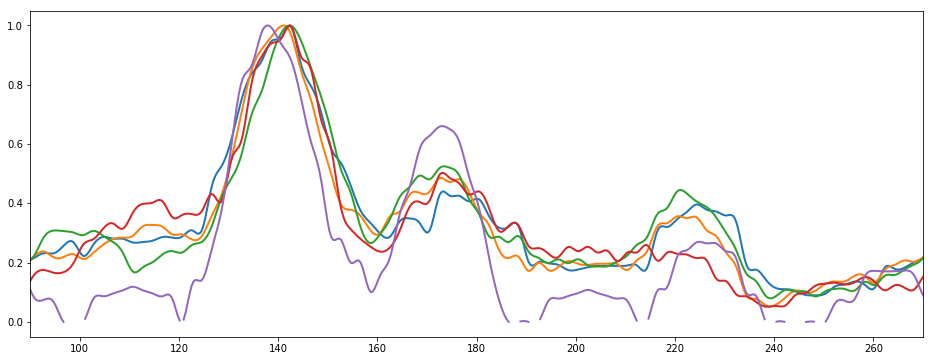

In [59]:
fig_plot = plt.figure(figsize=(16,6))
#plt.bar(np.linspace(1,360,len(y))-1, y, color='k',alpha=1)
for y in bigd.keys():
    plt.plot(np.linspace(1,360,len(bigd[y])),bigd[y]**2/np.nanmax(bigd[y]**2),'-',lw=2)
plt.xlim(90,270)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 21 but corresponding boolean dimension is 20


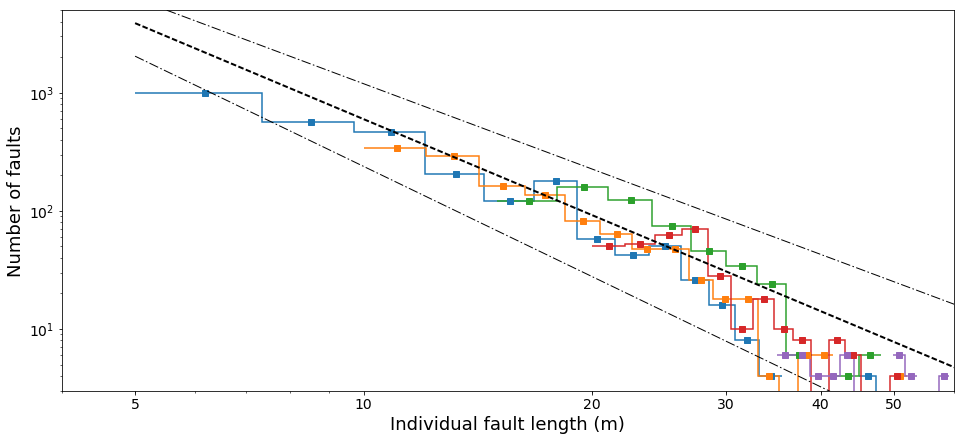

In [60]:
from scipy.optimize import curve_fit

prop_iter = iter(plt.rcParams['axes.prop_cycle'])

def line(x, a, b):
    return a * x + b

fig_lengthplot = plt.figure(figsize=(16,7))
#plt.bar(np.linspace(1,360,len(y))-1, y, color='k',alpha=1)
for y in bigdLength.keys():
    #plt.plot(np.linspace(1,360,len(bigd[y])),bigdLength[y]/np.nanmax(bigdLength[y]),'k-',lw=1)
    n, bins, patches = plt.hist(bigdLength[y], 20, normed=0, histtype='step',lw=1.5,zorder=0)
    bins[n == 0] =  np.nan
    n[n == 0] = np.nan
    plt.plot(bins[:-1]+(bins[1]-bins[0])/2, n, 's', color=next(prop_iter)['color'])
    '''xdata = bins[:-1]+(bins[1]-bins[0])/2
    logx = log10(xdata)
    logy = log10(n)
    idx = nonzero(n == 0)
    logx = np.delete(logx,idx)
    logy = np.delete(logy,idx)
    popt, pcov = curve_fit(line, logx, logy)
    plt.plot(xdata, (xdata**popt[0] * 10**(popt[1])))'''
    
plt.plot(np.linspace(5,60), 3e5 * np.linspace(5,60)**(-2.7),'k--',lw=2)
plt.plot(np.linspace(5,60), 3e5 * np.linspace(5,60)**(-3.1),'k-.',lw=1)
plt.plot(np.linspace(5,60), 3e5 * np.linspace(5,60)**(-2.4),'k-.',lw=1)
plt.ylabel('Number of faults', fontsize=18)
plt.xlabel('Individual fault length (m)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.semilogx()
plt.semilogy()
plt.xticks([5,10,20,30,40,50],[5,10,20,30,40,50])
#print bins, n
plt.xlim(4,60)
plt.ylim(3,5000)
plt.show()


In [5]:
from pylab import *
from scipy import *
from scipy.optimize import curve_fit


# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

##########
# Generate data points with noise
##########
num_points = len(bins)-1

# Note: all positive, non-zero data
xdata = bins[:-1]+(bins[1]-bins[0])/2
ydata = n     # simulated perfect data
yerr = ydata*0.2 #np.degrees(np.arctan2(1,xdata))                       # simulated errors (10%)





print ydata
#ydata += randn(num_points) * yerr       # simulated noisy data

##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

#ydata[ydata == 0]=np.NaN

xdata = bins[:-1]+(bins[1]-bins[0])/2
ydata = n     # simulated perfect data
logx = log10(xdata)
logy = log10(ydata)
idx = nonzero(ydata == 0)
logx = np.delete(logx,idx)
logy = np.delete(logy,idx)



def line(x, a, b):
    return a * x + b

popt, pcov = curve_fit(line, logx, logy)
#plot(xdata, (xdata**popt[0] * 10**(popt[1])))

print popt[0], popt[1]


'''
# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x   
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [2.5,-1.5]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print pfinal
print covar

index = pfinal[1]
amp = 10.0**pfinal[0]

#indexErr = sqrt( covar[0][0] ) 
#ampErr = sqrt( covar[1][1] ) * amp

##########'''
# Plotting data
##########

clf()
subplot(2, 1, 1)
#plot(xdata, powerlaw(xdata, amp, index))     # Fit
errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
#text(5, 6.5, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
#text(5, 5.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
title('Best Fit Power Law')
xlabel('X')
ylabel('Y')
#xlim(1, 11)

subplot(2, 1, 2)
plot(xdata, (xdata**popt[0] * 10**(popt[1])), 'r-')
errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
xlabel('X (log scale)')
ylabel('Y (log scale)')
#xlim(1.0, 11)
plt.semilogx()
plt.semilogy()

plt.show()


[  6.   6.  nan  nan   2.   2.   6.   2.   4.   4.  nan  nan   2.  nan  nan
  nan   4.  nan   2.   4.]


/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


ValueError: array must not contain infs or NaNs

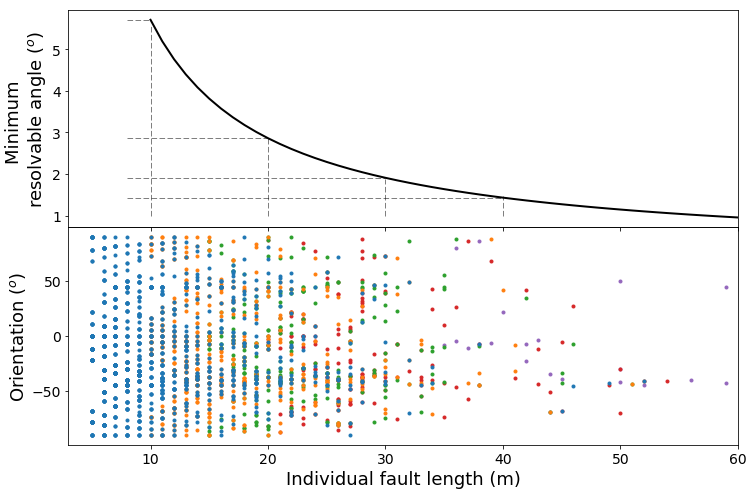

In [61]:

fig_lengthplot = plt.figure(figsize=(12,8))

ax1 = plt.subplot(212)
ax2 = plt.subplot(211, sharex=ax1)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

fig_lengthplot.subplots_adjust(hspace=0)

minTheta = np.degrees(np.arctan2(1,np.linspace(10,60,51)))

#plt.bar(np.linspace(1,360,len(y))-1, y, color='k',alpha=1)
ii = 0
for y in bigdLength.keys():
    #plt.plot(np.linspace(1,360,len(bigd[y])),bigdLength[y]/np.nanmax(bigdLength[y]),'k-',lw=1)
    ax1.plot(bigdLength[y][0:len(bigdLength[y])/2],bigdAzim[y],'.',zorder=10-ii)
    ii+=1
#plt.xlim(90,270)
ax1.set_ylabel('Orientation ($^o$)', fontsize=18)
ax1.set_xlabel('Individual fault length (m)', fontsize=18)
ax2.set_ylabel('Minimum \nresolvable angle ($^o$)', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.plot([20,20],np.linspace(1,2.9,2),'k--',lw=0.5)
ax2.plot([8,20],[np.degrees(np.arctan2(1,20))]*2,'k--',lw=0.5)
ax2.plot([10,10],np.linspace(1,5.55,2),'k--',lw=0.5)
ax2.plot([8,10],[np.degrees(np.arctan2(1,10))]*2,'k--',lw=0.5)
ax2.plot([30,30],np.linspace(1,1.87,2),'k--',lw=0.5)
ax2.plot([8,30],[np.degrees(np.arctan2(1,30))]*2,'k--',lw=0.5)
ax2.plot([40]*2,np.linspace(1,1.47,2),'k--',lw=0.5)
ax2.plot([8,40],[np.degrees(np.arctan2(1,40))]*2,'k--',lw=0.5)
ax2.plot(np.linspace(10,60,51),minTheta,'k-',lw=2)

#ax1.set_ylim(-90,1)
ax1.set_xlim(3,60)
plt.show()

## Exploring the impact of Threshold parameter

1.0 1.0
9.40377
1 0 min theta =  14.0362434679 ( 26.0 )
502
1 0 min theta =  6.34019174591 ( 57.0 )
509
1 0 min theta =  3.01278750418 ( 119.0 )
442
1 0 min theta =  1.97493401088 ( 182.0 )
380
1 0 min theta =  1.46880071439 ( 245.0 )
290


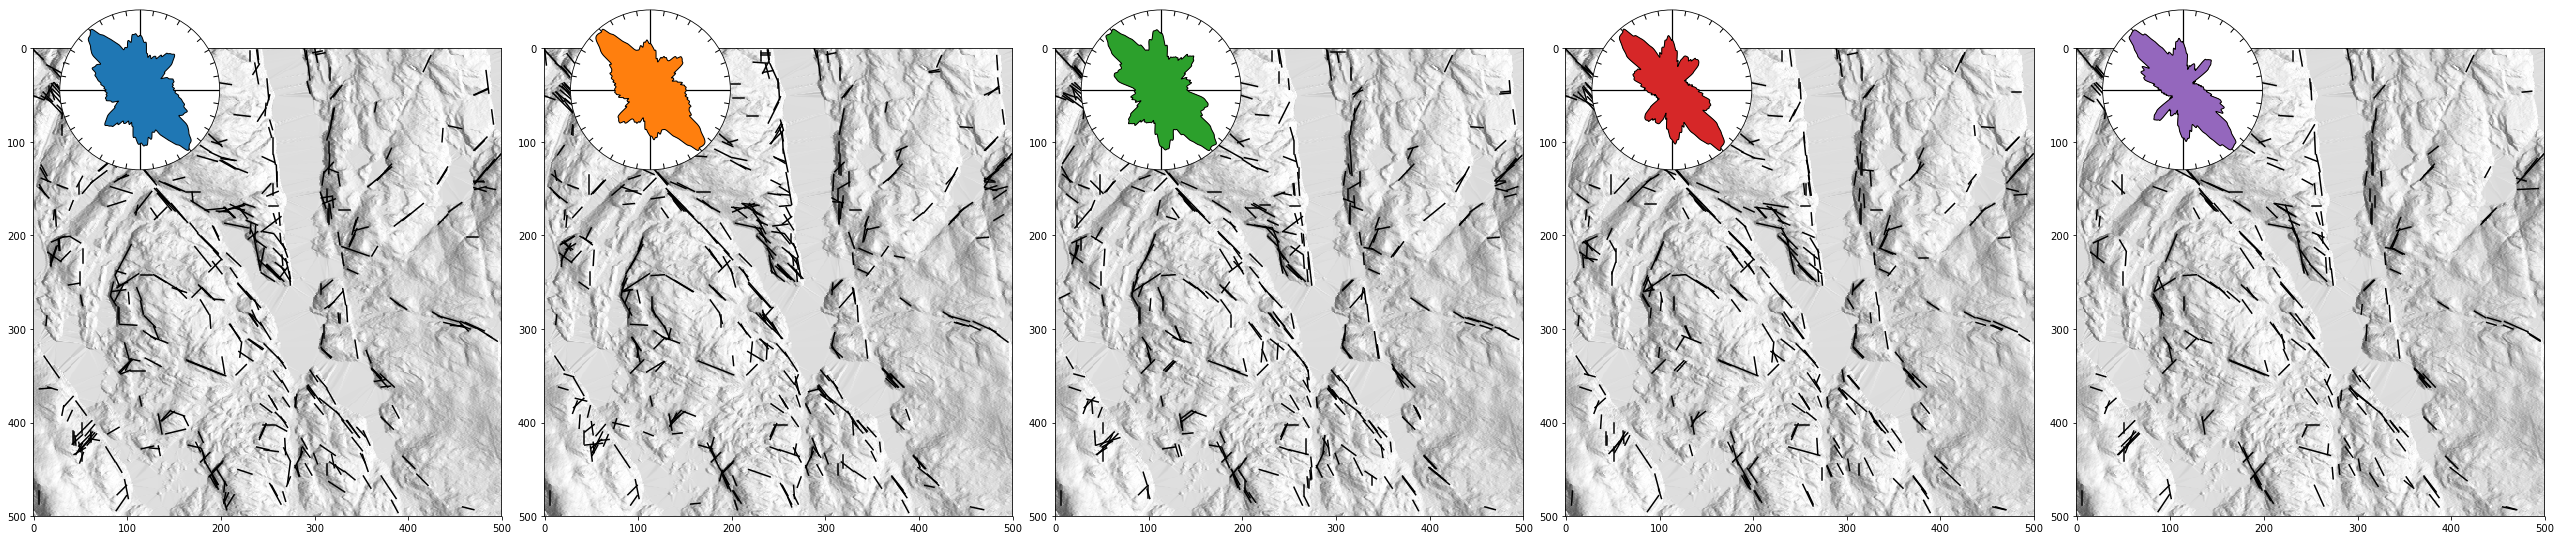

['1_1', '2_1', '3_1', '4_1', '5_1']


In [65]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap,shiftgrid#, cm
from matplotlib.colors import LightSource
from osgeo import osr, gdal
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import measure, feature, io, color, draw, morphology, restoration, filters
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from skimage.feature import canny
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import collections


fig = plt.figure(figsize=(45,10))


gs = gridspec.GridSpec(3, 10)

ax1 = plt.subplot(gs[:,0:2])
ax2 = plt.subplot(gs[:,2:4])
ax3 = plt.subplot(gs[:,4:6])
ax4 = plt.subplot(gs[:,6:8])
ax5 = plt.subplot(gs[:,8:10])



'''ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152)
ax3 = fig.add_subplot(153)
ax4 = fig.add_subplot(154)
ax5 = fig.add_subplot(155)'''
axes = [ax1,ax2,ax3,ax4,ax5]
lst = [1,1,1,1,1]
lst2 = [5,10,20,30,40]
if len(lst) != len(axes):
    raise NameError('The dimension of the list and the number of axes should be similar')
    

#gdal.UseExceptions()

fname = './Documents/Papers/LinearFeatureExtraction/goddo-lidar/Goddo-LiDAR.ovr'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5


extent = (xmin, xmax, ymin, ymax)

data = data[500:1000,500:1000]
data[data < 1.0] = np.nan
print xres,yres
vgrad = np.gradient(data,xres,yres)
slop = np.sqrt(vgrad[0]**2 + vgrad[1]**2)



print np.nanmax(slop)

#bin_grad = mag #> 0.05*np.nanmax(mag[3000:7000,5000:8000])

#apply gaussian filter
#bin_grad = ndimage.gaussian_filter(bin_grad, sigma=3)
bin_grad = slop > 1.0#*np.nanmax(mag)
#img = plt.imshow(bin_grad, cmap ='Greys_r')#, origin='upper')
#edges = canny(mag,sigma=7)



#Use mathematical image processing  techniques to clean the segmented images (erosion + propagation)
eroded_img = ndimage.binary_erosion(bin_grad)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=bin_grad)
#create mask of the segmented image and erode/propagate again
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
close_img = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))




#extract skeleton of the segmented image
skel = morphology.skeletonize(close_img)
#skel = np.logical_not(ndimage.binary_propagation(skel,mask=tmp))

#lines_1 = probabilistic_hough_line(skel, threshold=1, line_length=10, line_gap=5)
#lines_2 = probabilistic_hough_line(skel, threshold=2, line_length=10, line_gap=5)
#lines = probabilistic_hough_line(skel, threshold=3, line_length=10, line_gap=5)


ls = LightSource(azdeg=90,altdeg=45)
#img = plt.imshow(np.log(mag), cmap ='Greys_r')#, origin='upper')

cdict = {'red':   ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'green': ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'blue':  ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0))}

plt.register_cmap(name='hillshading', data=cdict)
    
    

  

#plt.imshow(edges, cmap ='Greys_r', origin='upper')

j = 0
idx = 1
bigd_t,bigdLength_t,bigdAzim_t = {},{},{}

for ax, i in zip(axes,lst):#,5,10]):
    m=0
    azim = []
    length = []
    colors = []
    lines = []
    minTheta = np.degrees(np.arctan2(1,lst2[idx-1]-1))
    while j < i:
        lines_i = probabilistic_hough_line(skel, threshold=lst2[idx-1], line_length= 10, line_gap=5)      
        lines = lines + lines_i 
        print i,j, 'min theta = ', minTheta, '(', np.round(360/minTheta,0), ')'
        j+=1
    if i == j:
        #print 'here'
        j=0
        img=ax.imshow(ls.hillshade(data, vert_exag=1),cmap='hillshading')#, extent=extent)#,interpolation='nearest')
        for line in lines:
            p0, p1 = line
            if p1[1] >= p0[1]: #check orientation of the line, we want to compute the angle from the north
                azim.append(np.arctan2(-float(p1[0]-p0[0]),float(p1[1]-p0[1]))*180./np.pi)
            else:
                azim.append(np.arctan2(-float(p0[0]-p1[0]),float(p0[1]-p1[1]))*180./np.pi)
            length.append(int(round(np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2),0)))#)//5))


            if azim[-1] < 0:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=-90, vmax=0)
                cmap = cm.RdBu
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
            else:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=0, vmax=90)
                cmap = cm.RdYlBu_r
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
        #ax.set_xticks([]) 
        #ax.set_yticks([])
        #ax3 = ax.add_axes((0.82, 0.82, 0.18, 0.18), frameon=True, projection='polar')
        
    
        #ax3 = inset_axes(ax, width="30%", height="30%", loc=3)
        #ax3.patch.set_transform(proj='polar')
        #ax3.patch.set_facecolor('w')
        #ax3 = fig.add_axes((),[0.2, 0.47, 0.30, 0.40], polar=True, axisbg='w')
        ax3 =fig.add_subplot(3, 2*len(lst), 2*idx-1, projection='polar')
        #gs = gridspec.GridSpec(3, 10)
        #ax3 = plt.subplot(gs[0:1,i:i+1], projection='polar')
        
        #process the azimuths data to produce rose diagram
        azimuths = np.asanyarray(azim)

        #ax3 = plt.gca()
        ax3.set_theta_direction(-1)
        ax3.set_theta_offset(np.radians(90))
        azimuths[azimuths < 0.0] += 180.0
        other = azimuths + 180.0
        azimuths = np.concatenate([azimuths, other])
        length = np.concatenate([length, length])

        #weighting the data as a function of fault lentgh
        azimuths2 = []
        k=0
        for n in azimuths :
            azimuths2.extend([n  for ii in range(length[k])])
            k+=1
        
        bins = np.round(360/minTheta,0)
        counts, edges = np.histogram(azimuths2, range=[0, 360], bins=180)
        
        #now do the weigthed average
        Ap = 9#int(np.round(minTheta,0))*2
        W = 0.9
        
        #compute r, the aperture  
        if Ap > 0:
            r = ((Ap-1)/2)
        elif Ap == 0:
            Ap = Ap
            
        #extend the original array of r in both directions. This is carried out in 
        #order to simulate both ends of the 1-D array being linked to
        #one another such that an average may now be ascertained at the 001
        #and 359 azimuths, and those in proximity to these, which incorporate 
        #the desired number of values on the opposite side of '0' or 'due north'.
        #Thus, the length of 1-D array 'p' is 'n+2r'.
        
        p = np.concatenate(([0]*r,counts,[0]*r), axis=0)
        
        for ii in range(0,r+1):
            p[r-ii] = counts[-ii]
            p[-ii] = counts[r-ii]

            
        #For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
        #r+1 to the maximum number of elements in the array minus 'r'), 
        #determine the sum of that array element plus those in within 'r' 
        #positions either side of it.  Divide this value by the number of
        #moving average for each 1 degree increment, or compass azimuth.  Store
        #each value sequentially in the new matrix array 'y'.
        y = []
        for f in xrange((r),(len(p)-r)):
            o = []
            for q in xrange((f-r),(f+r+1)):
                o.append(p[q]* np.power(W,(abs(f-q))))
            jj = np.sum([o])/Ap
            y.append(jj)
        
        y.append(y[0])
        
        #Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
        #1: First determine what percentage of the unweighted mean is represented by the weighted one:
        g = np.zeros(r)
        for ii in xrange(0,r):
            g[ii] = np.power(W,ii)
            
        g = 2.0*g
        scale = 1 + (np.sum(g))
        percent = (scale)/Ap
        #Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
        scalingfactor = 1.0/(percent)
        
        #Apply the scaling factor to the averaged dataset by multiplying each value by it.
        y = np.asarray(y)*scalingfactor
                       
        # Resample y data by a factor of 5 using cubic spline interpolation.
        y2 = ndimage.zoom(y, 5)
        y2 = np.sqrt(y2)
        for iii in  xrange(idx):
            ax3.fill_between(np.linspace(0,360./180.*np.pi,len(y2)), 0, y2,  alpha=1,zorder=5)
        ax3.plot(np.linspace(0,360./180.*np.pi,len(y2)),y2, color='k', linewidth=1,zorder=5)
        bigd_t['%s_%s'%(idx,i)] = y2
        bigdLength_t['%s_%s'%(idx,i)] = length
        bigdAzim_t['%s_%s'%(idx,i)] = azim
        counts = np.sqrt(y)
        coll = 0
 
     
        ax3.grid(False)
        ax3.set_thetagrids([],labels=[])
        ax3.set_yticklabels([])
        for ii in [0,90,180,270]:
            ax3.plot([np.radians(ii),np.radians(ii)],[0,np.max(counts)*1.02],color='k',linewidth=1.25, ls= '-', zorder=1)
        for ii in np.linspace(0,360,37):
            ax3.plot([np.radians(ii),np.radians(ii)],[np.max(counts)*0.98,np.max(counts)*1.1],color='k',
                     linewidth=1, ls= '-', zorder=1)

        ax3.set_rmax(np.max(counts)*1.04)
    idx +=1
    plt.draw()
            
    print m

#plt.tight_layout()
plt.show()


bigd_t = collections.OrderedDict(sorted(bigd_t.items()))
bigdLength_t = collections.OrderedDict(sorted(bigdLength_t.items()))
print bigd.keys()



1.0 1.0
9.40377
1 0
here
522
2 0
2 1
here
1055
3 0
3 1
3 2
here
1556
5 0
5 1
5 2
5 3
5 4
here
2619
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
here
5180


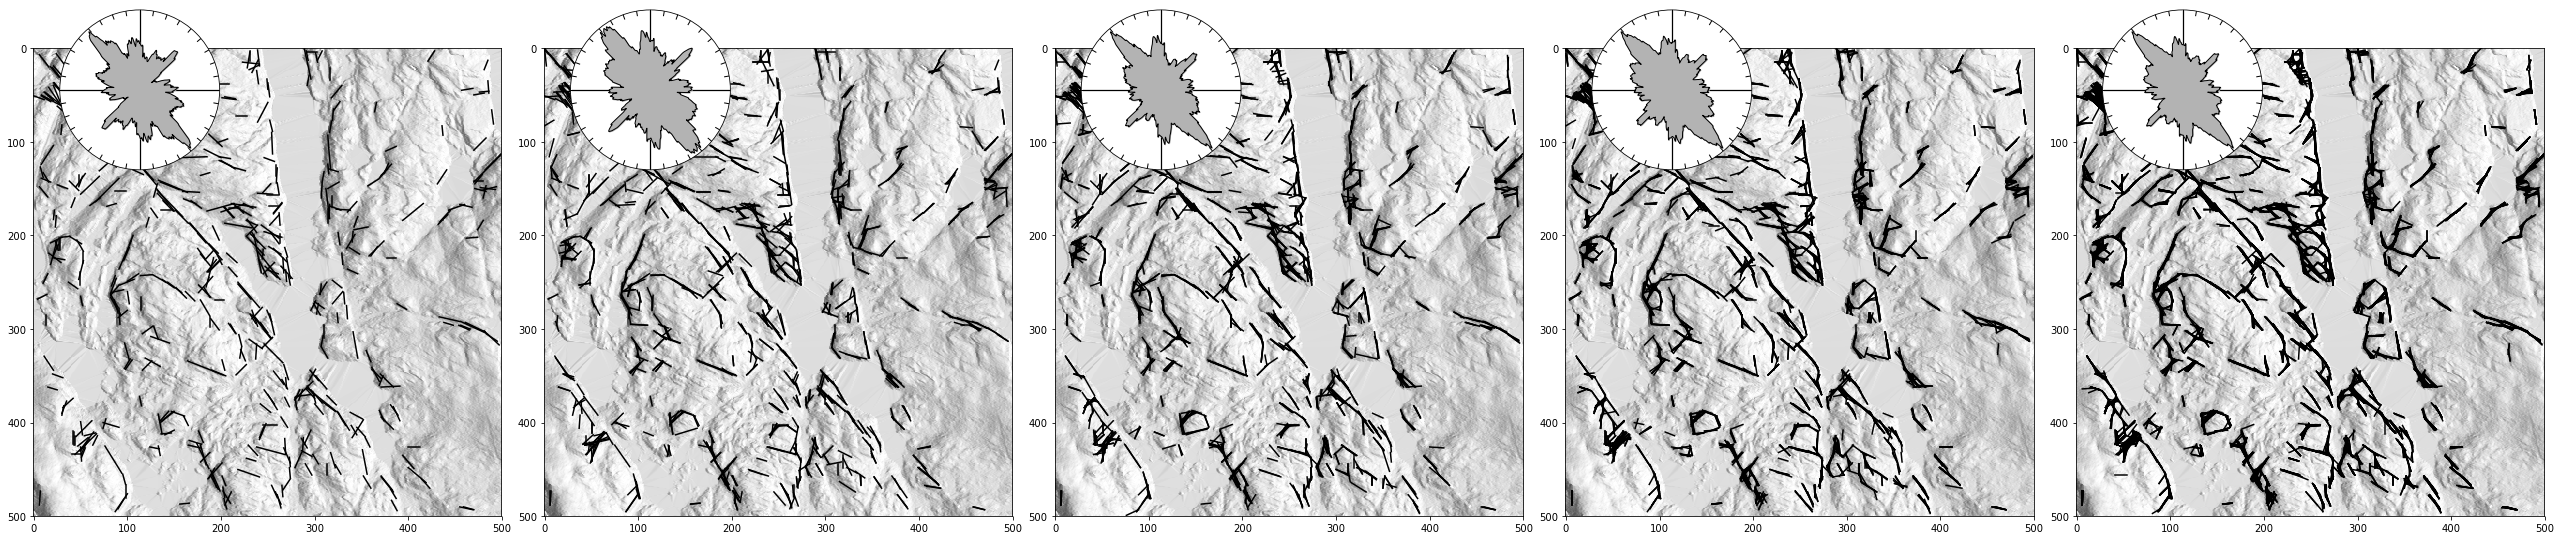

['2_2', '5_10', '3_3', '1_1', '4_5']


In [69]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap,shiftgrid#, cm
from matplotlib.colors import LightSource
from osgeo import osr, gdal
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import measure, feature, io, color, draw, morphology, restoration, filters
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from skimage.feature import canny
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec


fig2 = plt.figure(figsize=(45,10))


gs = gridspec.GridSpec(3, 10)

ax1 = plt.subplot(gs[:,0:2])
ax2 = plt.subplot(gs[:,2:4])
ax3 = plt.subplot(gs[:,4:6])
ax4 = plt.subplot(gs[:,6:8])
ax5 = plt.subplot(gs[:,8:10])



'''ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152)
ax3 = fig.add_subplot(153)
ax4 = fig.add_subplot(154)
ax5 = fig.add_subplot(155)'''
axes = [ax1,ax2,ax3,ax4,ax5]
lst = [1,2,3,5,10]

if len(lst) != len(axes):
    raise NameError('The dimension of the list and the number of axes should be similar')
    

#gdal.UseExceptions()

fname = './Documents/Papers/LinearFeatureExtraction/goddo-lidar/Goddo-LiDAR.ovr'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5


extent = (xmin, xmax, ymin, ymax)

data = data[500:1000,500:1000]
data[data < 1.0] = np.nan
print xres,yres
vgrad = np.gradient(data,xres,yres)
slop = np.sqrt(vgrad[0]**2 + vgrad[1]**2)

#sob = filters.sobel(data)

print np.nanmax(slop)

#bin_grad = mag #> 0.05*np.nanmax(mag[3000:7000,5000:8000])

#apply gaussian filter
#bin_grad = ndimage.gaussian_filter(bin_grad, sigma=3)
bin_grad = slop > 1.0#*np.nanmax(mag)
#img = plt.imshow(bin_grad, cmap ='Greys_r')#, origin='upper')
#edges = canny(mag,sigma=7)



#Use mathematical image processing  techniques to clean the segmented images (erosion + propagation)
eroded_img = ndimage.binary_erosion(bin_grad)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=bin_grad)
#create mask of the segmented image and erode/propagate again
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
close_img = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))


#extract skeleton of the segmented image
skel = morphology.skeletonize(close_img)
#skel = np.logical_not(ndimage.binary_propagation(skel,mask=tmp))

#lines_1 = probabilistic_hough_line(skel, threshold=1, line_length=10, line_gap=5)
#lines_2 = probabilistic_hough_line(skel, threshold=2, line_length=10, line_gap=5)
#lines = probabilistic_hough_line(skel, threshold=3, line_length=10, line_gap=5)


ls = LightSource(azdeg=90,altdeg=45)
#img = plt.imshow(np.log(mag), cmap ='Greys_r')#, origin='upper')

cdict = {'red':   ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'green': ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'blue':  ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0))}

plt.register_cmap(name='hillshading', data=cdict)
    
    

  

#plt.imshow(edges, cmap ='Greys_r', origin='upper')

j = 0
idx = 1
bigd2 = {}

for ax, i in zip(axes,lst):#,5,10]):
    m=0
    azim = []
    length = []
    colors = []
    lines = []
    
    while j < i:
        lines_i = probabilistic_hough_line(skel, threshold=5, line_length=10, line_gap=5)      
        lines = lines + lines_i 
        print i,j
        j+=1
    if i == j:
        print 'here'
        j=0
        img=ax.imshow(ls.hillshade(data, vert_exag=1),cmap='hillshading')#, extent=extent)#,interpolation='nearest')
        for line in lines:
            p0, p1 = line
            if p1[1] >= p0[1]: #check orientation of the line, we want to compute the angle from the north
                azim.append(np.arctan2(-float(p1[0]-p0[0]),float(p1[1]-p0[1]))*180./np.pi)
            else:
                azim.append(np.arctan2(-float(p0[0]-p1[0]),float(p0[1]-p1[1]))*180./np.pi)
            length.append(int(round(np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2),0)))#)//5))


            if azim[-1] < 0:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=-90, vmax=0)
                cmap = cm.RdBu
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
            else:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=0, vmax=90)
                cmap = cm.RdYlBu_r
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
        #ax.set_xticks([]) 
        #ax.set_yticks([])
        #ax3 = ax.add_axes((0.82, 0.82, 0.18, 0.18), frameon=True, projection='polar')
        
    
        #ax3 = inset_axes(ax, width="30%", height="30%", loc=3)
        #ax3.patch.set_transform(proj='polar')
        #ax3.patch.set_facecolor('w')
        #ax3 = fig.add_axes((),[0.2, 0.47, 0.30, 0.40], polar=True, axisbg='w')
        ax3 = fig2.add_subplot(3, 2*len(lst), 2*idx-1, projection='polar')
        #gs = gridspec.GridSpec(3, 10)
        #ax3 = plt.subplot(gs[0:1,i:i+1], projection='polar')
        
        #process the azimuths data to produce rose diagram
        azimuths = np.asanyarray(azim)

        #ax3 = plt.gca()
        ax3.set_theta_direction(-1)
        ax3.set_theta_offset(np.radians(90))
        azimuths[azimuths < 0.0] += 180.0
        other = azimuths + 180.0
        azimuths = np.concatenate([azimuths, other])
        length = np.concatenate([length, length])

        #weighting the data as a function of fault lentgh
        azimuths2 = []
        k=0
        for n in azimuths :
            azimuths2.extend([n  for ii in range(length[k])])
            k+=1

        counts, edges = np.histogram(azimuths2, range=[0, 360], bins=360)
        
        #now do the weigthed average
        Ap = 9
        W = 0.9
        
        #compute r, the aperture  
        if Ap > 0:
            r = ((Ap-1)/2)
        elif Ap == 0:
            Ap = Ap
            
        #extend the original array of r in both directions. This is carried out in 
        #order to simulate both ends of the 1-D array being linked to
        #one another such that an average may now be ascertained at the 001
        #and 359 azimuths, and those in proximity to these, which incorporate 
        #the desired number of values on the opposite side of '0' or 'due north'.
        #Thus, the length of 1-D array 'p' is 'n+2r'.
        
        p = np.concatenate(([0]*r,counts,[0]*r), axis=0)
        
        for ii in range(0,r+1):
            p[r-ii] = counts[-ii]
            p[-ii] = counts[r-ii]

            
        #For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
        #r+1 to the maximum number of elements in the array minus 'r'), 
        #determine the sum of that array element plus those in within 'r' 
        #positions either side of it.  Divide this value by the number of
        #moving average for each 1 degree increment, or compass azimuth.  Store
        #each value sequentially in the new matrix array 'y'.
        y = []
        for f in xrange((r),(len(p)-r)):
            o = []
            for q in xrange((f-r),(f+r+1)):
                o.append(p[q]* np.power(W,(abs(f-q))))
            jj = np.sum([o])/Ap
            y.append(jj)
        
        y.append(y[0])
        
        #Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
        #1: First determine what percentage of the unweighted mean is represented by the weighted one:
        g = np.zeros(r)
        for ii in xrange(0,r):
            g[ii] = np.power(W,ii)
            
        g = 2.0*g
        scale = 1 + (np.sum(g))
        percent = (scale)/Ap
        #Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
        scalingfactor = 1.0/(percent)
        
        #Apply the scaling factor to the averaged dataset by multiplying each value by it.
        y = np.asarray(y)*scalingfactor
                       
        # Resample y data by a factor of 5 using cubic spline interpolation.
        y2 = ndimage.zoom(y, 5)
        y2 = np.sqrt(y2)
        ax3.fill_between(np.linspace(0,360./180.*np.pi,len(y2)), 0, y2, color = '0.7', alpha=1,zorder=5)
        ax3.plot(np.linspace(0,360./180.*np.pi,len(y2)),y2, color='k', linewidth=1,zorder=5)
        bigd2['%s_%s'%(idx,i)] = y2
        counts = np.sqrt(y)
        coll = 0
 
     
        ax3.grid(False)
        ax3.set_thetagrids([],labels=[])
        ax3.set_yticklabels([])
        for ii in [0,90,180,270]:
            ax3.plot([np.radians(ii),np.radians(ii)],[0,np.max(counts)*1.02],color='k',linewidth=1.25, ls= '-', zorder=1)
        for ii in np.linspace(0,360,37):
            ax3.plot([np.radians(ii),np.radians(ii)],[np.max(counts)*0.98,np.max(counts)*1.1],color='k',
                     linewidth=1, ls= '-', zorder=1)

        ax3.set_rmax(np.max(counts)*1.04)
    idx +=1
    plt.draw()
            
    print m

#plt.tight_layout()
plt.show()

print bigd2.keys()



1.0 1.0
9.40377
1 0 min theta =  6.34019174591 ( 57.0 )
306
2 0 min theta =  6.34019174591 ( 57.0 )
2 1 min theta =  6.34019174591 ( 57.0 )
585
3 0 min theta =  6.34019174591 ( 57.0 )
3 1 min theta =  6.34019174591 ( 57.0 )
3 2 min theta =  6.34019174591 ( 57.0 )
889
5 0 min theta =  6.34019174591 ( 57.0 )
5 1 min theta =  6.34019174591 ( 57.0 )
5 2 min theta =  6.34019174591 ( 57.0 )
5 3 min theta =  6.34019174591 ( 57.0 )
5 4 min theta =  6.34019174591 ( 57.0 )
1478
10 0 min theta =  6.34019174591 ( 57.0 )
10 1 min theta =  6.34019174591 ( 57.0 )
10 2 min theta =  6.34019174591 ( 57.0 )
10 3 min theta =  6.34019174591 ( 57.0 )
10 4 min theta =  6.34019174591 ( 57.0 )
10 5 min theta =  6.34019174591 ( 57.0 )
10 6 min theta =  6.34019174591 ( 57.0 )
10 7 min theta =  6.34019174591 ( 57.0 )
10 8 min theta =  6.34019174591 ( 57.0 )
10 9 min theta =  6.34019174591 ( 57.0 )
2982


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:258: RuntimeWarning: invalid value encountered in sqrt


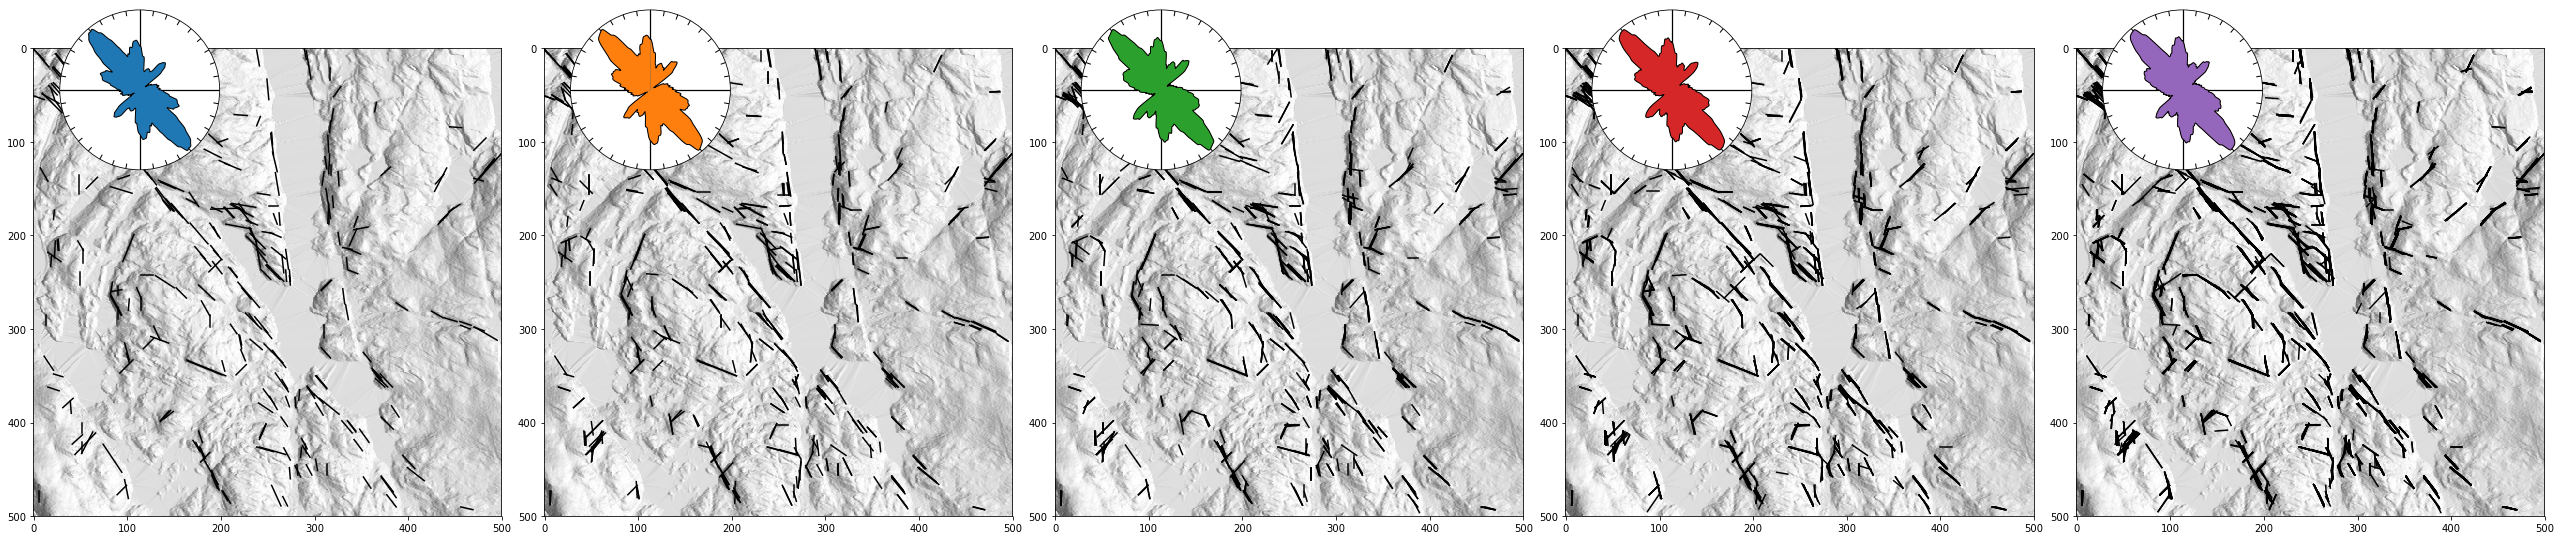

['1_1', '2_2', '3_3', '4_5', '5_10']


In [99]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap,shiftgrid#, cm
from matplotlib.colors import LightSource
from osgeo import osr, gdal
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import measure, feature, io, color, draw, morphology, restoration, filters
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from skimage.feature import canny
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import collections


fig = plt.figure(figsize=(45,10))


gs = gridspec.GridSpec(3, 10)

ax1 = plt.subplot(gs[:,0:2])
ax2 = plt.subplot(gs[:,2:4])
ax3 = plt.subplot(gs[:,4:6])
ax4 = plt.subplot(gs[:,6:8])
ax5 = plt.subplot(gs[:,8:10])



'''ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152)
ax3 = fig.add_subplot(153)
ax4 = fig.add_subplot(154)
ax5 = fig.add_subplot(155)'''
axes = [ax1,ax2,ax3,ax4,ax5]
lst = [1,2,3,5,10]
lst2 = [10,10,10,10,10]
if len(lst) != len(axes):
    raise NameError('The dimension of the list and the number of axes should be similar')
    

#gdal.UseExceptions()

fname = './Documents/Papers/LinearFeatureExtraction/goddo-lidar/Goddo-LiDAR.ovr'

ds = gdal.Open(fname)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5


extent = (xmin, xmax, ymin, ymax)

data = data[500:1000,500:1000]
data[data < 1.0] = np.nan
print xres,yres
vgrad = np.gradient(data,xres,yres)
slop = np.sqrt(vgrad[0]**2 + vgrad[1]**2)



print np.nanmax(slop)


bin_grad = slop > 1.0#*np.nanmax(mag)



#Use mathematical image processing  techniques to clean the segmented images (erosion + propagation)
eroded_img = ndimage.binary_erosion(bin_grad)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=bin_grad)
#create mask of the segmented image and erode/propagate again
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
close_img = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))




#extract skeleton of the segmented image
skel = morphology.skeletonize(close_img)
#skel = np.logical_not(ndimage.binary_propagation(skel,mask=tmp))

#lines_1 = probabilistic_hough_line(skel, threshold=1, line_length=10, line_gap=5)
#lines_2 = probabilistic_hough_line(skel, threshold=2, line_length=10, line_gap=5)
#lines = probabilistic_hough_line(skel, threshold=3, line_length=10, line_gap=5)


ls = LightSource(azdeg=90,altdeg=45)
#img = plt.imshow(np.log(mag), cmap ='Greys_r')#, origin='upper')

cdict = {'red':   ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'green': ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0)),
         'blue':  ((0.0,  0.3, 0.3),
                   (1.0,  1.0, 1.0))}

plt.register_cmap(name='hillshading', data=cdict)
    
    

  

#plt.imshow(edges, cmap ='Greys_r', origin='upper')

j = 0
idx = 1
bigd_t,bigdLength_t,bigdAzim_t = {},{},{}

for ax, i in zip(axes,lst):#,5,10]):
    m=0
    azim = []
    length = []
    colors = []
    lines = []
    minTheta = np.degrees(np.arctan2(1,lst2[idx-1]-1))
    while j < i:
        lines_i = probabilistic_hough_line(skel, threshold=40, line_length= 10, line_gap=5)      
        lines = lines + lines_i 
        print i,j, 'min theta = ', minTheta, '(', np.round(360/minTheta,0), ')'
        j+=1
    if i == j:
        #print 'here'
        j=0
        img=ax.imshow(ls.hillshade(data, vert_exag=1),cmap='hillshading')#, extent=extent)#,interpolation='nearest')
        for line in lines:
            p0, p1 = line
            if p1[1] >= p0[1]: #check orientation of the line, we want to compute the angle from the north
                azim.append(np.arctan2(-float(p1[0]-p0[0]),float(p1[1]-p0[1]))*180./np.pi)
            else:
                azim.append(np.arctan2(-float(p0[0]-p1[0]),float(p0[1]-p1[1]))*180./np.pi)
            length.append(int(round(np.sqrt((p1[1]-p0[1])**2+(p1[0]-p0[0])**2),0)))#)//5))


            if azim[-1] < 0:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=-90, vmax=0)
                cmap = cm.RdBu
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
            else:
                #colour the line as a function of its azimuth
                norm = mpl.colors.Normalize(vmin=0, vmax=90)
                cmap = cm.RdYlBu_r
                n = cm.ScalarMappable(norm=norm, cmap=cmap)
                color = n.to_rgba((azim[-1]))
                colors.append(color)
                #if p1[1] > 300*1024./1200 and p0[1] < 900*1024./1200:
                ax.plot((p0[0], p1[0]),(p0[1], p1[1]), lw=1.5,zorder=3, color='k')
                m+=1
        #ax.set_xticks([]) 
        #ax.set_yticks([])
        #ax3 = ax.add_axes((0.82, 0.82, 0.18, 0.18), frameon=True, projection='polar')
        
    
        #ax3 = inset_axes(ax, width="30%", height="30%", loc=3)
        #ax3.patch.set_transform(proj='polar')
        #ax3.patch.set_facecolor('w')
        #ax3 = fig.add_axes((),[0.2, 0.47, 0.30, 0.40], polar=True, axisbg='w')
        ax3 =fig.add_subplot(3, 2*len(lst), 2*idx-1, projection='polar')
        #gs = gridspec.GridSpec(3, 10)
        #ax3 = plt.subplot(gs[0:1,i:i+1], projection='polar')
        
        #process the azimuths data to produce rose diagram
        azimuths = np.asanyarray(azim)

        #ax3 = plt.gca()
        ax3.set_theta_direction(-1)
        ax3.set_theta_offset(np.radians(90))
        azimuths[azimuths < 0.0] += 180.0
        other = azimuths + 180.0
        azimuths = np.concatenate([azimuths, other])
        length = np.concatenate([length, length])

        #weighting the data as a function of fault lentgh
        azimuths2 = []
        k=0
        for n in azimuths :
            azimuths2.extend([n  for ii in range(length[k])])
            k+=1
        
        bins = np.round(360/minTheta,0)
        counts, edges = np.histogram(azimuths2, range=[0, 360], bins=180)
        
        #now do the weigthed average
        Ap = 9#int(np.round(minTheta,0))*2
        W = 0.9
        
        #compute r, the aperture  
        if Ap > 0:
            r = ((Ap-1)/2)
        elif Ap == 0:
            Ap = Ap
            
        #extend the original array of r in both directions. This is carried out in 
        #order to simulate both ends of the 1-D array being linked to
        #one another such that an average may now be ascertained at the 001
        #and 359 azimuths, and those in proximity to these, which incorporate 
        #the desired number of values on the opposite side of '0' or 'due north'.
        #Thus, the length of 1-D array 'p' is 'n+2r'.
        
        p = np.concatenate(([0]*r,counts,[0]*r), axis=0)
        
        for ii in range(0,r+1):
            p[r-ii] = counts[-ii]
            p[-ii] = counts[r-ii]

            
        #For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
        #r+1 to the maximum number of elements in the array minus 'r'), 
        #determine the sum of that array element plus those in within 'r' 
        #positions either side of it.  Divide this value by the number of
        #moving average for each 1 degree increment, or compass azimuth.  Store
        #each value sequentially in the new matrix array 'y'.
        y = []
        for f in xrange((r),(len(p)-r)):
            o = []
            for q in xrange((f-r),(f+r+1)):
                o.append(p[q]* np.power(W,(abs(f-q))))
            jj = np.sum([o])/Ap
            y.append(jj)
        
        y.append(y[0])
        
        #Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
        #1: First determine what percentage of the unweighted mean is represented by the weighted one:
        g = np.zeros(r)
        for ii in xrange(0,r):
            g[ii] = np.power(W,ii)
            
        g = 2.0*g
        scale = 1 + (np.sum(g))
        percent = (scale)/Ap
        #Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
        scalingfactor = 1.0/(percent)
        
        #Apply the scaling factor to the averaged dataset by multiplying each value by it.
        y = np.asarray(y)*scalingfactor
                       
        # Resample y data by a factor of 5 using cubic spline interpolation.
        y2 = ndimage.zoom(y, 5)
        y2 = np.sqrt(y2)
        for iii in  xrange(idx):
            ax3.fill_between(np.linspace(0,360./180.*np.pi,len(y2)), 0, y2,  alpha=1,zorder=5)
        ax3.plot(np.linspace(0,360./180.*np.pi,len(y2)),y2, color='k', linewidth=1,zorder=5)
        bigd_t['%s_%s'%(idx,i)] = y2
        bigdLength_t['%s_%s'%(idx,i)] = length
        bigdAzim_t['%s_%s'%(idx,i)] = azim
        counts = np.sqrt(y)
        coll = 0
 
     
        ax3.grid(False)
        ax3.set_thetagrids([],labels=[])
        ax3.set_yticklabels([])
        for ii in [0,90,180,270]:
            ax3.plot([np.radians(ii),np.radians(ii)],[0,np.max(counts)*1.02],color='k',linewidth=1.25, ls= '-', zorder=1)
        for ii in np.linspace(0,360,37):
            ax3.plot([np.radians(ii),np.radians(ii)],[np.max(counts)*0.98,np.max(counts)*1.1],color='k',
                     linewidth=1, ls= '-', zorder=1)

        ax3.set_rmax(np.max(counts)*1.04)
    idx +=1
    plt.draw()
            
    print m

#plt.tight_layout()
plt.show()


bigd_t = collections.OrderedDict(sorted(bigd_t.items()))
bigdLength_t = collections.OrderedDict(sorted(bigdLength_t.items()))
print bigd_t.keys()




1_1
2_2
3_3
4_5
5_10
[<matplotlib.lines.Line2D object at 0x13b31f250>, <matplotlib.lines.Line2D object at 0x153f2ced0>, <matplotlib.lines.Line2D object at 0x150470110>, <matplotlib.lines.Line2D object at 0x150470750>, <matplotlib.lines.Line2D object at 0x150470d90>]


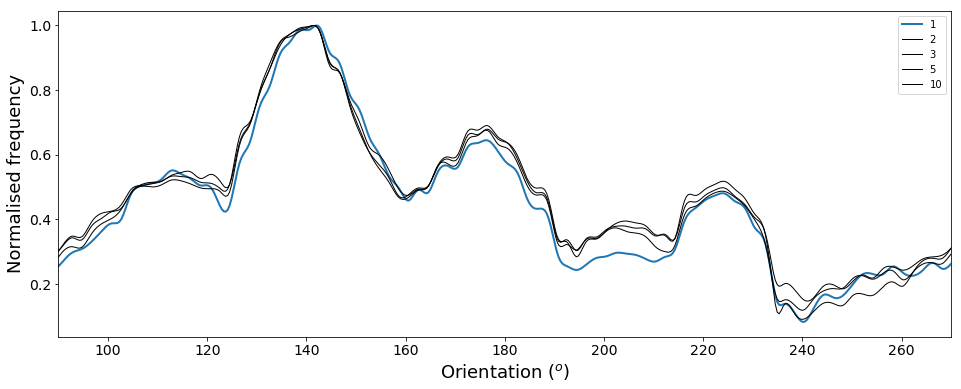

In [164]:
fig_plot = plt.figure(figsize=(16,6))
ax = plt.gca()
#plt.bar(np.linspace(1,360,len(y))-1, y, color='k',alpha=1)
for y in bigd_t.keys():
    print y
    if y[:1] == '1':
        ax.plot(np.linspace(1,360,len(bigd_t[y])),bigd_t[y]/np.max(bigd_t[y]), '-', lw=2, label='%s'%y[2:])
    else:
        ax.plot(np.linspace(1,360,len(bigd_t[y])),bigd_t[y]/np.max(bigd_t[y]), 'k-', lw=1, label='%s'%y[2:],zorder=y[:1])
plt.xlim(90,270)
handles, labels = ax.get_legend_handles_labels()
print handles
plt.legend()
plt.ylabel('Normalised frequency', fontsize=18)
plt.xlabel('Orientation ($^o$)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

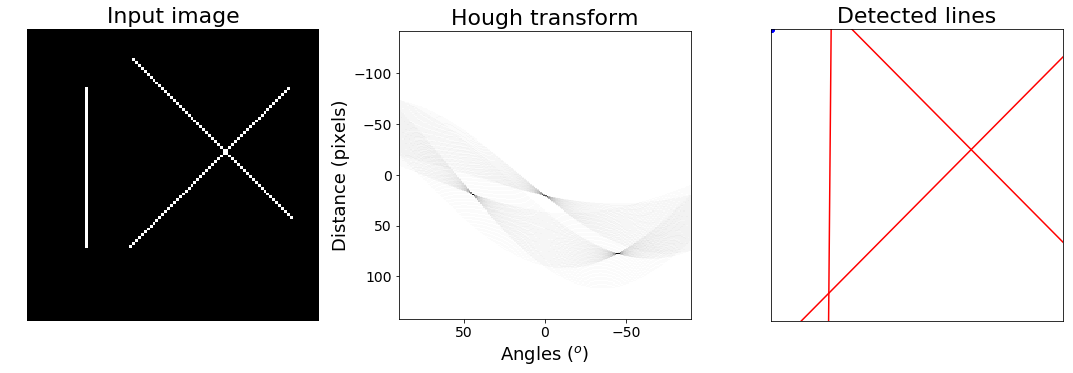

In [163]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
#from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(20, 75)
image[idx[::-1], idx + 15] = 255
image[idx[::-1]-10, -idx + 10] = 255
image[idx,20] = 255

#image = skel


#bin_grad = sob >  3#0.50*np.nanmax(sob)

#Use mathematical image processing  techniques to clean the segmented images (erosion + propagation)
eroded_img = ndimage.binary_erosion(bin_grad)
reconstruct_img = ndimage.binary_propagation(eroded_img, mask=bin_grad)
#create mask of the segmented image and erode/propagate again
tmp = np.logical_not(reconstruct_img)
eroded_tmp = ndimage.binary_erosion(tmp)
close_img = np.logical_not(ndimage.binary_propagation(eroded_tmp, mask=tmp))

#extract skeleton of the segmented image
skel2 = morphology.skeletonize(close_img)

h, theta, d = hough_line(image)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,12))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image', fontsize=22)
ax1.set_axis_off()

#ax2.imshow(np.log(1 + h),extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),d[-1], d[0]],
#             cmap=plt.cm.gray, aspect=1/8.)
ax2.imshow( h, extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),d[-1], d[0]],
             cmap=plt.cm.gray_r, aspect=1/1.6)

ax2.set_title('Hough transform', fontsize=22)
ax2.set_xlabel('Angles ($^o$)', fontsize=18)
ax2.set_ylabel('Distance (pixels)', fontsize=18)

#ax2.axis('image')

#ax3.imshow(sob, cmap=plt.cm.gray)
rows, cols = image.shape
ang = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    ang.append(angle)
    ax3.plot((0, cols), (y0, y1), '-r')
    ax3.plot(0,0,'bo')
    #ax3.plot(rows, cols,'go')
ax3.axis((0, cols, rows, 0))
ax3.set_title('Detected lines', fontsize=22)
ax3.set_aspect('equal')
ax3.set_xticks([])
ax3.set_yticks([])


ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
#ax3.set_axis_off()
#ang = np.rad2deg(ang)
'''
ax4.hist(ang, 20, normed=1, facecolor='green')
'''
plt.tight_layout()
plt.show()

azi =  29064


<function matplotlib.pyplot.show>

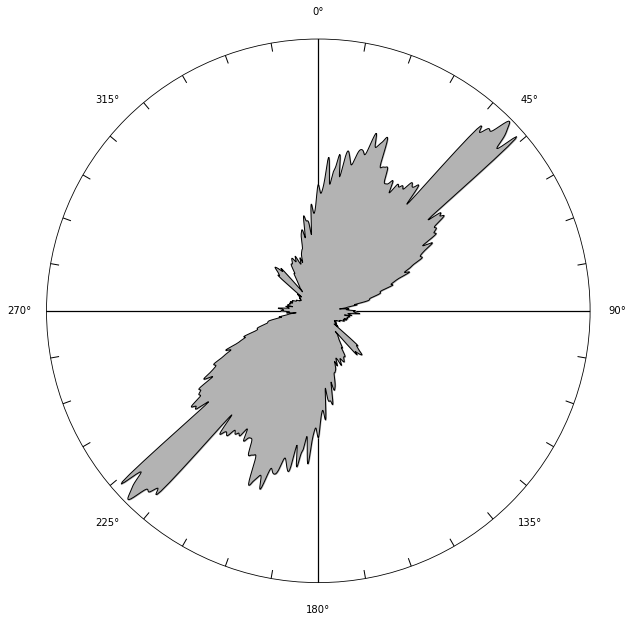

In [19]:
azim2 = np.asanyarray(azim)
azim2 = np.round_(azim2, decimals=2)

#azimuths = azimuths + 2*(np.random.rand(1)-0.5)
azim2[azim2 < 0.0] += 180.0

other = azim2 + 180.0
azimuths = np.concatenate([azim2, other])
length = np.concatenate([length, length])


print 'azi = ', len(azimuths)


#weighting the data as a function of fault lentgh
azimuths2 = []
j=0
for n in azimuths :
    azimuths2.extend([n  for i in range(length[j])])
    j+=1
    


#print len(azimuths), azimuths
#print len(azimuths2), np.asanyarray(azimuths2)    
#print len(length),length


#counts, edges = np.histogram(azimuths, range=[-2.5, 357.5], bins=bins)
counts, edges = np.histogram(azimuths2, range=[0, 360], bins=360)


#print counts


Ap = 9
W = 0.9

#compute r, the aperture  
if Ap > 0:
    r = ((Ap-1)/2)
elif Ap == 0:
    Ap = Ap

#extend the original array of r in both directions. This is carried out in 
#order to simulate both ends of the 1-D array being linked to
#one another such that an average may now be ascertained at the 001
#and 359 azimuths, and those in proximity to these, which incorporate 
#the desired number of values on the opposite side of '0' or 'due north'.
#Thus, the length of 1-D array 'p' is 'n+2r'.

p = np.concatenate(([0]*r,counts,[0]*r), axis=0)



for i in range(0,r+1):
    p[r-i] = counts[-i]
    p[-i] = counts[r-i]
#print np.asarray(p)


#For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
#r+1 to the maximum number of elements in the array minus 'r'), 
#determine the sum of that array element plus those in within 'r' 
#positions either side of it.  Divide this value by the number of
#moving average for each 1 degree increment, or compass azimuth.  Store
#each value sequentially in the new matrix array 'y'.
y = []
for f in xrange((r),(len(p)-r)):
    o = []
    for q in xrange((f-r),(f+r+1)):
        o.append(p[q]* np.power(W,(abs(f-q))))
    j = np.sum([o])/Ap
    y.append(j)

y.append(y[0])

#Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
#1: First determine what percentage of the unweighted mean is represented by the weighted one:
g = np.zeros(r)
for i in xrange(0,r):
    g[i] = np.power(W,i)
    
g = 2.0*g
scale = 1 + (np.sum(g))
percent = (scale)/Ap
#Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
scalingfactor = 1.0/(percent)

#Apply the scaling factor to the averaged dataset by multiplying each value by it.
y = np.asarray(y)*scalingfactor
    

    
# Resample y data by a factor of 5 using cubic spline interpolation.
y = ndimage.zoom(y, 5)




#c2 = ax.plot(np.linspace(0,360./180.*np.pi,361), y, color='k', linewidth=1)
#ax.fill_betweenx(np.linspace(0,360./180.*np.pi,361), np.zeros(shape=(1,361)).flatten(), y, color='r')
#ax.fill_between(np.linspace(0,360./180.*np.pi,361), 0, y, color = 'k', alpha=1)


fig = plt.figure(figsize=(10,10))
#plt.bar(np.linspace(1,360,len(y))-1, y, color='k',alpha=1)
#plt.plot(np.linspace(1,360,361),y/np.max(y),'r-',lw=2)

#y=np.sqrt(y)

ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.fill_between(np.linspace(0,360./180.*np.pi,len(y)), 0, (y), color = '0.7', alpha=1, zorder=2)
#ax.plot(x/180.*np.pi, d, color='r', linewidth=1)
ax.plot(np.linspace(0,360./180.*np.pi,len(y)),y, color='k', linewidth=1,zorder=2)
ax.grid(False)
ax.set_yticklabels([])
for i in [0,90,180,270]:
    ax.plot([np.radians(i),np.radians(i)],[0,np.max(y)*1.1],color='k',linewidth=1.25, ls= '-', zorder=1)

for i in np.linspace(0,360,37):
    ax.plot([np.radians(i),np.radians(i)],[np.max(y)*0.98,np.max(y)*1.1],color='k',linewidth=1, ls= '-', zorder=1)


ax.set_rmax(np.max((y))*1.01)
plt.show

In [ ]:
dat = [146,144,139,148,144,138,137,156,135,136,114,157,146,168,149,138,128,110,147,134,125,136,170,162,151,142,144,142,141,140,144,157,180,159,138,144,148,161,149,162,181,126,175,131,156,153,149,142,139,232,132,120,172,144,149,158,161,148,147,134,149,137,148,120,147,165,159,154,136,149,150,155,139,153,142,131,138,170,141,141,148,123,178,183,124,131,141,144,123,156,138,136,143,138,180,151,157,149,143,152,142,131,188,149,156,149,147,166,124,129,140,142,129,150,149,145,142,158,140,139,168,153,152,131,137,150,179,184,152,144,165,148,133,148,157,178,174,148,154,149,151,147,166,181,154,135,149,152,122,185,142,144,147,129,147,152,141,158,150,137,142,162,167,152,131,153,141,128,122,160,149,120,154,151,140,143,149,134,145,153,146,147,149,152,160,158,148,149,160,144,157,145,146,158,149,148,137,163,168,149,145,146,149,142,148,149,132,137,161,138,180,183,132,123,148,178,149,152,181,148,152,134,136,130,154,148,147,145,152,173,156,142,153,151,141,134,147,144,143,158,172,170,154,142,160,156,152,180,163,151,162,151,106,141,143,133,135,142,148,138,146,143,149,164,142,147,177,132,130,157,150,175,143,156,130,154,151,165,151,140,162,105,167,152,157,159,148,153,145,143,128,178,119,152,137,148,144,143,129,158,153,147,142,133,138,124,141,148,139,142,127,148,102,140,123,134,138,136,181,169,135,143,153,144,131,156,160,151,176,155,153,140,143,133,146,132,148,153,146,150,146,155,151,149,149,153,152,137,147,144,156,128,188,143,168,139,130,157,142,134,147,152,127,147,138,155,144,140,158,164,146,136,153,141,142,155,136,134,130,133,140,148,147,156,129,152,132,145,128,157,148,139,142,175,152,143,140,156,145,157,184,146,148,159,157,145,147,142,127,136,134,128,145,145,171,158,134,146,141,139,166,153,181,125,140,142,152,156,156,161,154,141,140,158,162,160,157,127,150,158,152,143,90,141,153,138,151,152,120,142,161,167,162,149,141,153,140,154]

dat = [188,162,171,171,170,153,158,177,172,158,110,121,254,203,197,193,204,184,187,188,191,181,217,207,180,185,197,172,175,184,195,196,231,194,159,197,180,214,226,214,195,182,188,136,198,142,161,159,191,178,170,230,177,152,176,157,167,177,191,171,193,186,192,208,189,187,251,180,202,183,163,187,97,217,185,229,197,191,183,215,207,164,172,200,218,201,169,181,185,166,192,193,174,191,181,162,168,169,235,160,240,220,220,180,248,228,195,201,206,221,181,184,206,172,192,215,182,241,163,164,182,171,186,208,235,242,248,188,168,233,138,193,222,91,264,176,184,186,171,170,122,152,159,169,168,199,201,169,190,183,167,185,235,92,220,221,197,179,191,209,199,240,236,174,151,203,220,232,216,198,257,185,103,228,182,158,261,219,199,221,174,156,193,194,202,207,166,128,219,214,172,191,194,193,175,141,156,128,151,181,140,256,211,262,243,215,228,240,158,206,176,265,183,261,239,131,226,218,220,235,190,219,225,222,249,202,251,105,203,205,192,213,240,238,247,132,228,243,130,128,184,208,114,194,191,102,188,187,187,174,156,172,186,203,248,267,112,156,172,185,188,188,156,148,230,227,118,197,164,142,100,161,175,164,173,250,228,201,166,184,193,166,211,175,156,133,155,163,187,201,142,154,222,231,146,157,166,160,147,178,173,163,194,210,175,188,95,166,186,133,146,153,160,147,158,174,189,245,239,161,110,195,194,172,167,179,266,171,141,187,247,176,199,229,163,124,175,165,174,191,240,187,246,203,183,146,242,211,205,236,223,185,190,268,206,202,211,225,236,232,218,251,206,240,221,108,209,213,249,241,208,232,228,232,188,243,190,208,209,215,262,95,95,192,195,222,236,237,208,167,187,179,200,192,203,197,173,198,157,174,202,196,247,219,212,187,156,173,220,172,214,198,210,228,166,197,188,192,184,171,211,230,242,198,212,193,223,182,184,166,183,176,190,187,166,194,222,169,212,188,262,180,189,206,241,205,216,258,147,149,226,214,171,225,236,222,230,239,220,186,191,209,184,182,204,254,219,191,217,198,197,218,210,198,158,167,211,166,231,93,195,192,196,199,200,178,181,178,190,120,131,173,189,193,198,238,168,232,207,200,139,215,234,237,200,155,159,207,205,181,189,138,195,105,135,207,210,174,188,193,222,219,195,194,195,188,209,193,185,165,168,244,182,170,174,203,170,187,225,177,157,189,191,155,184,183,147,146,108,103,191,146,161,165,126,133,155,138,145,99,164,188,181,151,163,157,135,183,168,221,242,216,212,223,171,183,178,171,189,205,143,141,124,207,225,169,182,170,182,196,147,143,172,174,166,173,197,187,192,190,172,158,185,176,170,206,185,195,184,155,168,217,209,227,193,200,166,173,214,196,230,232,178,192,175,170,234,226,199,196,187,197,207,206,198,206,233,200,199,195,217,190,164,186,182,199,188,212,189,248,221,217,202,193,207,201,197,226,197,215,194,196,188,191,172,192,215,203,197,152,173,238,214,155,187,168,177,176,181,182,221,191,201,197,179,207,176,160,185,192,218,229,164,149,140,187,263,172,201,185,184,156,186,156,189,186,174,181,202,182,214,169,196,210,203,232,207,184,185,189,181,166,161,201,163,176,108,258,255,175,172,175,186,173,173,188,184,183,158,227,207,175,110,107,109,173,238,146,161,145,155,212,204,213,230,225,192,150,147,160,202,205,211,196,161,203,217,210,264,232,208,197,185,185,170,212,217,188,198,191,208,234,196,193,231,162,203,223,217,209,205,210,181,190,193,172,205,202,216,238,216,165,182,237,164,229,150,193,187,232,198,182,161,209,176,197,202,202,194,232,192,190,149,234,198,182,144,155,167,150,103,125,200,173,220,182,185,188,190,156,161,155,206,254,219,194,185,173,181,190,191,220,223,239,104,184,190,220,219,188,210,204,191,261,93,182,162,195,199,130,174,184,165,186,199,205,188,220,228,190,217,188,145,238,193,199,181,189,188,183,160,185,165,205,186,172,217,183,188,210,249,166,192,239,204,155,239,229,216,185,199,212,132,135,234,213,242,238,255,195,230,185,188,197,192,188,226,161,218,197,178,194,244,233,230,183,233,196,233,178,179,188,189,170,188,160,196,212,200,197,215,163,193,185,196,206,188,236,155,170,156,158,175,202,166,214,256,185,181,146,138,167,171,186,186,157,162,197,179,165,163,164,169,140,165,161,153,162,188,166,134,145,156,190,159,162,161,194,191,194,172,184,176,176,148,166,167,158,188,189,166,162,166,204,189,170,151,200,214,247,202,174,174,203,196,183,150,166,163,164,184,202,185,222,184,184,235,196,205,203,259,130,226,226,203,184,203,202,197,234,233,202,226,175,195,193,200,172,191,197,205,234,172,183,187,173,183,219,195,164,193,185,98,202,245,244,222,168,141,181,140,148,135,130,220,202,198,173,148,166,239,217,190,202,212,252,187,201,181,184,178,155,192,182,194,208,182,188,177,184,238,202,208,162,187,222,199,191,193,156,221,146,192,192,193,188,155,171,219,178,197,181,216,192,191,175,162,166,213,212,205,233,188,183,165,162,195,207,205,206,165,228,188,218,195,191,193,188,141,175,193,194,191,188,262,112,162,195,203,188,203,163,172,186,166,182,205,219,171,198,161,142,172,174,157,170,182,176,186,183,175,195,212,240,146,170,168,170,223,196,189,228,207,190,189,190,188,190,188,189,199,213,183,206,206,151,230,192,193,163,204,202,184,189,194,155,183,181,182,170,194,205,192,183,192,232,202,207,223,211,188,255,172,171,179,204,196,195,217,235,187,232,240,207,213,193,234,222,227,159,194,185,252,197,176,155,181,203,198,213,235,234,196,223,173,166,202,211,182,191,195,197,213,224,217,228,192,240,203,223,191,210,201,194,194,212,189,171,194,185,188,198,232,222,175,184,176,175,175,171,194,243,182,207,206,193,205,253,215,159,158,149,153,161,207,185,169,112,120,188,184,183,192,176,168,191,182,174,165,185,193,193,198,182,189,153,152,169,199,173,182,194,197,195,199,185,184,187,188,192,189,213,198,192,187,182,198,172,196,207,183,184,196,171,208,198,170,172,184,197,167,152,184,181,185,167,178,169,168,138,137,198,197,243,203,204,238,233,181,204,153,160,229,219,163,157,182,198,245,154,181,204,208,178,153,197,191,93,193,206,158,203,163,182,124,188,198,206,209,263,198,186,247,163,184,205,163,151,182,181,191,211,185,203,166,187]

In [ ]:
counts, edges = np.histogram(dat, range=[0, 360], bins=360)

print counts


Ap = 9
W = 1

#compute r, the aperture  
if Ap > 0:
    r = ((Ap-1)/2)
elif Ap == 0:
    Ap = Ap

#extend the original array of r in both directions. This is carried out in 
#order to simulate both ends of the 1-D array being linked to
#one another such that an average may now be ascertained at the 001
#and 359 azimuths, and those in proximity to these, which incorporate 
#the desired number of values on the opposite side of '0' or 'due north'.
#Thus, the length of 1-D array 'p' is 'n+2r'.

p = np.concatenate(([0]*r,counts,[0]*r), axis=0)



for i in range(0,r+1):
    p[r-i] = counts[-i]
    p[-i] = counts[r-i]
print np.asarray(p)


#For every azimuth from 001 to 360 in array 'p' (i.e. array elements 
#r+1 to the maximum number of elements in the array minus 'r'), 
#determine the sum of that array element plus those in within 'r' 
#positions either side of it.  Divide this value by the number of
#moving average for each 1 degree increment, or compass azimuth.  Store
#each value sequentially in the new matrix array 'y'.
y = []
for f in xrange((r),(len(p)-r)):
    o = []
    for q in xrange((f-r),(f+r+1)):
        o.append(p[q]* np.power(W,(abs(f-q))))
    j = np.sum([o])/Ap
    y.append(j)

y.append(y[0])

#Determine the factor by which the frequencies are reduced relative to an equivalent unweighted moving average.
#1: First determine what percentage of the unweighted mean is represented by the weighted one:
g = np.zeros(r)
for i in xrange(0,r):
    g[i] = np.power(W,i)
    
g = 2.0*g
scale = 1 + (np.sum(g))
percent = (scale)/Ap
#Now determine the value by which the current dataset must be multiplied by to compensate for the down-scaling.
scalingfactor = 1.0/(percent)

#Apply the scaling factor to the averaged dataset by multiplying each value by it.
y = np.asarray(y)*scalingfactor
    


#c2 = ax.plot(np.linspace(0,360./180.*np.pi,361), y, color='k', linewidth=1)
#ax.fill_betweenx(np.linspace(0,360./180.*np.pi,361), np.zeros(shape=(1,361)).flatten(), y, color='r')
#ax.fill_between(np.linspace(0,360./180.*np.pi,361), 0, y, color = 'k', alpha=1)


fig = plt.figure(figsize=(10,10))
#plt.bar(np.linspace(1,360,361)-1, counts, color='k',alpha=1)
#plt.hist(d,np.linspace[0,359,359],color='green',alpha=0.8)
#plt.plot(np.linspace(1,360,361),y/np.max(y),'r-',lw=2)


ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.fill_between(np.linspace(0,360./180.*np.pi,361), 0, np.sqrt(y), color = 'k', alpha=1)
#ax.plot(x/180.*np.pi, d, color='r', linewidth=1)
ax.plot(np.linspace(0,360./180.*np.pi,361),y/scalingfactor, color='r', linewidth=2)
ax.grid(False)
ax.set_yticklabels([])
ax.set_rmax(np.max(np.sqrt(y))*1.05)
plt.show